In [2]:
#THIS IS USED FOR TRAINING ON COMPUTER
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

path_test = 'D:/OneDrive - VietNam National University - HCM INTERNATIONAL UNIVERSITY/Code/CapstoneDraft/Data/mitbih_test.csv'
path_train = 'D:/OneDrive - VietNam National University - HCM INTERNATIONAL UNIVERSITY/Code/CapstoneDraft/Data/mitbih_train.csv'
mit_test = pd.read_csv(path_test,header=None)
mit_train = pd.read_csv(path_train, header=None)

#Replace columns 187 with Class
mit_test.rename(columns={187:"Class"}, inplace=True)
mit_train.rename(columns={187:"Class"}, inplace=True)

In [ ]:
model_load = tf.keras.models.load_model("CVDs_1_2.h5")
model_load.summary()

In [ ]:
test, out_test = mit_test.iloc[:,:187], mit_test["Class"]
test = normalize(test, axis = 0, norm='max')
x_test = test.reshape(test.shape[0],test.shape[1],1)

y_test = to_categorical(out_test)
print(x_test.shape)
x_test= np.float32(x_test)

In [ ]:
pred_test = model_load.evaluate (x_test, y_test)

In [ ]:
# Setting Dictionary to define the type of Heartbeat
# N: normal
#S: Supraventricular premature beat
#P: Premature ventricular contraction
#F: Fusion of ventricular and normal beat
#U: Unclassifiable beat
MIT_Outcome = {0. : 'N',
               1. : 'S',
               2. : 'P',
               3. : 'F',
               4. : 'U'}

In [ ]:
pred_test = model_load.predict (x_test)
model_pred_test = np.argmax(pred_test,axis=1)

In [ ]:
print(classification_report(out_test, model_pred_test, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))


In [1]:
import numpy as np
import os
import wfdb
from collections import Counter
import pickle
import random
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

label_group_map = {'N': 0., 'L':0., 'R':0., 'V':2., '/':4., 'A':1., 'F':3., 'f':4., 'j':1., 'a':1., 'E':2., 'J':1., 'e':1., 'Q':1., 'S':1.}

def resample_unequal(ts, fs_in, fs_out):
    """
    interploration
    """
    fs_in, fs_out = int(fs_in), int(fs_out)
    if fs_out == fs_in:
        return ts
    else:
        x_old = np.linspace(0, 1, num=fs_in, endpoint=True)
        x_new = np.linspace(0, 1, num=fs_out, endpoint=True)
        y_old = ts
        f = interp1d(x_old, y_old, kind='linear')
        y_new = f(x_new)
        return y_new

if __name__ == "__main__":

    path = 'mit-bih-arrhythmia-database-1.0.0'
    save_path = 'data/'
    # valid_lead = ['MLII', 'II', 'I', 'MLI', 'V5'] 
    valid_lead = ['MLII'] 
    fs_out = 360
    test_ratio = 0.2

    train_ind = []
    test_ind = []
    all_pid = []
    all_data = []
    all_label = []
    all_group = []

    with open(os.path.join(path, 'RECORDS'), 'r') as fin:
        all_record_name = fin.read().strip().split('\n')
    test_pid = random.choices(all_record_name, k=int(len(all_record_name)*test_ratio))
    train_pid = list(set(all_record_name) - set(test_pid))
    for record_name in all_record_name:
        try:
            tmp_ann_res = wfdb.rdann(path + '/' + record_name, 'atr').__dict__
            tmp_data_res = wfdb.rdsamp(path + '/' + record_name)
        except:
            print('read data failed')
            continue
        fs = tmp_data_res[1]['fs']
        
        ## total 1 second for each
        left_offset = int(1.0*fs / 2)
        right_offset = int(fs) - int(1.0*fs / 2)

        lead_in_data = tmp_data_res[1]['sig_name']
        my_lead_all = []
        for tmp_lead in valid_lead:
            if tmp_lead in lead_in_data:
                my_lead_all.append(tmp_lead)
        if len(my_lead_all) != 0:
            for my_lead in my_lead_all:
                channel = lead_in_data.index(my_lead)
                tmp_data = tmp_data_res[0][:, channel]

                idx_list = list(tmp_ann_res['sample'])
                label_list = tmp_ann_res['symbol']
                for i in range(len(label_list)):
                    s = label_list[i]
                    if s in label_group_map.keys():
                        idx_start = idx_list[i]-left_offset
                        idx_end = idx_list[i]+right_offset
                        if idx_start < 0 or idx_end > len(tmp_data):
                            continue
                        else:
                            all_pid.append(record_name)
                            all_data.append(resample_unequal(tmp_data[idx_start:idx_end], fs, fs_out))
                            all_label.append(s)
                            all_group.append(label_group_map[s])
                            if record_name in train_pid:
                                train_ind.append(True)
                                test_ind.append(False)
                            else:
                                train_ind.append(False)
                                test_ind.append(True)
                    else:
                        continue
                print('record_name:{}, lead:{}, fs:{}, cumcount: {}'.format(record_name, my_lead, fs, len(all_pid)))
        else:
            print('lead in data: [{0}]. no valid lead in {1}'.format(lead_in_data, record_name))
            continue

    all_pid = np.array(all_pid)
    all_data = np.array(all_data)
    all_label = np.array(all_label)
    all_group = np.array(all_group)
    train_ind = np.array(train_ind)
    test_ind = np.array(test_ind)
    print(all_data.shape)
    print(all_label.shape, np.sum(train_ind), np.sum(test_ind))
    print(Counter(all_label))
    print(Counter(all_group))
    print(Counter(all_group[train_ind]))
    print(Counter(all_group[test_ind]))
    #np.save(os.path.join(save_path, 'mitdb_data.npy'), all_data)
    #np.save(os.path.join(save_path, 'mitdb_label.npy'), all_label)
    #np.save(os.path.join(save_path, 'mitdb_group.npy'), all_group)
    #np.save(os.path.join(save_path, 'mitdb_pid.npy'), all_pid)
    #np.save(os.path.join(save_path, 'mitdb_train_ind.npy'), train_ind)
    #np.save(os.path.join(save_path, 'mitdb_test_ind.npy'), test_ind)
    
    print(all_data.shape)
    print(all_group.shape)

record_name:100, lead:MLII, fs:360, cumcount: 2271
record_name:101, lead:MLII, fs:360, cumcount: 4135
lead in data: [['V5', 'V2']]. no valid lead in 102
record_name:103, lead:MLII, fs:360, cumcount: 6218
lead in data: [['V5', 'V2']]. no valid lead in 104
record_name:105, lead:MLII, fs:360, cumcount: 8790
record_name:106, lead:MLII, fs:360, cumcount: 10817
record_name:107, lead:MLII, fs:360, cumcount: 12953
record_name:108, lead:MLII, fs:360, cumcount: 14715
record_name:109, lead:MLII, fs:360, cumcount: 17245
record_name:111, lead:MLII, fs:360, cumcount: 19369
record_name:112, lead:MLII, fs:360, cumcount: 21906
record_name:113, lead:MLII, fs:360, cumcount: 23699
record_name:114, lead:MLII, fs:360, cumcount: 25578
record_name:115, lead:MLII, fs:360, cumcount: 27529
record_name:116, lead:MLII, fs:360, cumcount: 29940
record_name:117, lead:MLII, fs:360, cumcount: 31474
record_name:118, lead:MLII, fs:360, cumcount: 33751
record_name:119, lead:MLII, fs:360, cumcount: 35738
record_name:121, l

In [7]:

multi_heartbeat = np.zeros((1,400), dtype = float)
heartbeat = []
for i in range(all_data.shape[0]):
    heartbeat = all_data[i]
    #print(heartbeat)
    heartbeat = np.append(heartbeat, np.zeros((1, 400 - (all_data.shape[1])), dtype = float))
    multi_heartbeat = np.insert(multi_heartbeat, -1, heartbeat, axis = 0)
multi_heartbeat = np.delete(multi_heartbeat, -1, axis = 0)


KeyboardInterrupt: 

In [11]:
from wfdb import processing
def normalize_ECG(signal):
    nor_sig = np.zeros((signal.shape[0], signal.shape[1]), dtype = float)
    for i in range(len(signal)):
        nor_sig[i] = processing.normalize_bound(signal[i], lb=0, ub=1)
    return nor_sig

In [12]:
new = normalize_ECG(all_data)

print(new.shape)

(105026, 360)


In [6]:
a = 10004
plt.plot(all_data[a])
print(all_data[2].shape)
print(all_group[a])

plt.plot(multi_heartbeat[1])

(360,)
2.0


In [1]:
import numpy as np
import os
import wfdb
from collections import Counter
import pickle
import random
import sys
from tqdm import tqdm

label_group_map = {'N': 0., 'L':0., 'R':0., 'V':2., '/':4., 'A':1., 'F':3., 'f':4., 'j':1., 'a':1., 'E':2., 'J':1., 'e':1., 'Q':1., 'S':1.}

def resample_unequal(ts, fs_in, fs_out):
    """
    interploration
    """
    fs_in, fs_out = int(fs_in), int(fs_out)
    if fs_out == fs_in:
        return ts
    else:
        x_old = np.linspace(0, 1, num=fs_in, endpoint=True)
        x_new = np.linspace(0, 1, num=fs_out, endpoint=True)
        y_old = ts
        f = interp1d(x_old, y_old, kind='linear')
        y_new = f(x_new)
        return y_new

if __name__ == "__main__":

    path = 'mit-bih-arrhythmia-database-1.0.0'
    save_path = 'data/'
    # valid_lead = ['MLII', 'II', 'I', 'MLI', 'V5'] 
    valid_lead = ['MLII'] 
    fs_out = 360
    test_ratio = 0.2

    train_ind = []
    test_ind = []
    all_pid = []
    all_data = []
    all_label = []
    all_group = []

    with open(os.path.join(path, 'RECORDS'), 'r') as fin:
        all_record_name = fin.read().strip().split('\n')
    test_pid = random.choices(all_record_name, k=int(len(all_record_name)*test_ratio))
    train_pid = list(set(all_record_name) - set(test_pid))

    for record_name in all_record_name:
        try:
            tmp_ann_res = wfdb.rdann(path + '/' + record_name, 'atr').__dict__
            tmp_data_res = wfdb.rdsamp(path + '/' + record_name)
            tmp_data = tmp_data_res[0].flatten()
        except:
            print('read data failed')
            continue
        fs = tmp_data_res[1]['fs']
        ## total 1 second for each
        left_offset = int(1.0*fs / 2)
        right_offset = int(fs) - int(1.0*fs / 2)

        lead_in_data = tmp_data_res[1]['sig_name']
        my_lead_all = []
        for tmp_lead in valid_lead:
            if tmp_lead in lead_in_data:
                my_lead_all.append(tmp_lead)
        if len(my_lead_all) != 0:
            R_peaks = np.zeros((tmp_data, 1), dtype = float)
            for my_lead in my_lead_all:
                channel = lead_in_data.index(my_lead)
                tmp_data = tmp_data_res[0][:, channel]

                idx_list = list(tmp_ann_res['sample'])
                label_list = tmp_ann_res['symbol']
                for i in range(len(label_list)):
                    s = label_list[i]
                    if s in label_group_map.keys():
                        idx_start = idx_list[i]-left_offset
                        idx_end = idx_list[i]+right_offset
                        if idx_start < 0 or idx_end > len(tmp_data):
                            continue
                        else:
                            all_pid.append(record_name)
                            all_data.append(resample_unequal(tmp_data[idx_start:idx_end], fs, fs_out))
                            all_label.append(s)
                            all_group.append(label_group_map[s])
                            if record_name in train_pid:
                                train_ind.append(True)
                                test_ind.append(False)
                            else:
                                train_ind.append(False)
                                test_ind.append(True)
                    else:
                        continue
                print('record_name:{}, lead:{}, fs:{}, cumcount: {}'.format(record_name, my_lead, fs, len(all_pid)))
        else:
            print('lead in data: [{0}]. no valid lead in {1}'.format(lead_in_data, record_name))
            continue

    all_pid = np.array(all_pid)
    all_data = np.array(all_data)
    all_label = np.array(all_label)
    all_group = np.array(all_group)
    train_ind = np.array(train_ind)
    test_ind = np.array(test_ind)
    print(all_data.shape)
    print(all_label.shape, np.sum(train_ind), np.sum(test_ind))
    print(Counter(all_label))
    print(Counter(all_group))
    print(Counter(all_group[train_ind]))
    print(Counter(all_group[test_ind]))
    #np.save(os.path.join(save_path, 'mitdb_data.npy'), all_data)
    #np.save(os.path.join(save_path, 'mitdb_label.npy'), all_label)
    #np.save(os.path.join(save_path, 'mitdb_group.npy'), all_group)
    #np.save(os.path.join(save_path, 'mitdb_pid.npy'), all_pid)
    #np.save(os.path.join(save_path, 'mitdb_train_ind.npy'), train_ind)
    #np.save(os.path.join(save_path, 'mitdb_test_ind.npy'), test_ind)
    
    print(all_group.shape)

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
print(all_pid.shape)
print(all_data.shape)
plt.plot(all_data[100])

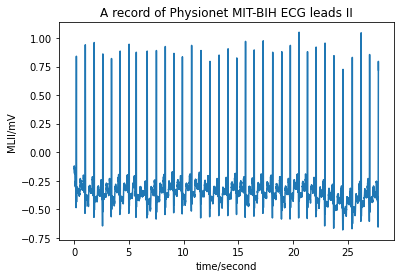

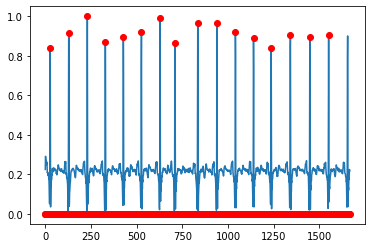

<class 'numpy.ndarray'>


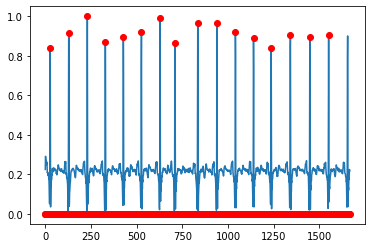

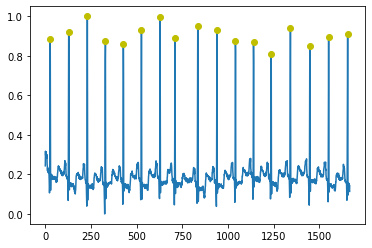

(8, 187)


In [1]:
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
from biosppy.signals import ecg
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram

def zero_to_nan(array):
    """ Return nan for any value = 0"""
    return [float('nan') if x==0 else x for x in array]

def find_vertex(arr):
  """Return array with vertexs of the input array"""
  #Size of the vertex array = sizr of input array
  arr_v = np.zeros((arr.shape[0],), dtype = float)
  for i in range(arr.shape[0]):
    #Index j and k for finding vertex
    if i<arr.shape[0]-1:
      j = i + 1
    else:
      j = i
    if i>0:
      k = i - 1
    else:
      k = i
    if i>0 & i<arr.shape[0]-1:
      if (arr[i] > arr[j]) & (arr[i] > arr[k]) & (arr[i]>=0.6):
        arr_v[i] = arr[i]
  #any values = 0 will be nan
  arr_v = zero_to_nan(arr_v)
  return arr_v

def normalizeECG(signal):
    max = signal[0]
    min = signal[0]
    
    for i in range(len(signal)):
        if(signal[i]>max):
            max = signal[i]
        if(signal[i]<min):
            min = signal[i]
            
    normalSig = (signal - min)/(max-min)
    return normalSig

def process_beat(signal):
  signal = normalizeECG(signal)
  #signal = signal.reshape(signal.shape[0], 1)
  #signal = sklearn.preprocessing.normalize(signal)
  heartbeat = []
  multi_heartbeat = []
  multi_heartbeat = np.zeros((1,187), dtype = float)
  R_peaks = find_vertex(signal)  
  j = 0
  c_p = 0
  R_inter = np.zeros((2,), dtype = int)
  for i in range(len(signal)):
      if R_peaks[i] == signal[i]:
        R_inter[c_p] = i
        c_p = c_p + 1
      if c_p == 2:
        c_p = 0
        crop_signal = signal[R_inter[0]:R_inter[1]+20].flatten()
        heartbeat = crop_signal 
        heartbeat = np.append(heartbeat, np.zeros((1,187 - len(crop_signal)), dtype = float))
        heartbeat = np.reshape(heartbeat,(1, len(heartbeat)))
        #print(f"heartbeat = {heartbeat}")
        multi_heartbeat = np.insert(multi_heartbeat, -1, heartbeat, axis = 0)
        #print(f"multi_heartbeat = {multi_heartbeat}")
  multi_heartbeat = np.delete(multi_heartbeat, -1, axis = 0)      
  #print(multi_heartbeat.shape)
  print(multi_heartbeat.shape)
  return multi_heartbeat

path = 'mit-bih-arrhythmia-database-1.0.0/100'

freq_model = 125
number_of_sample = 168
sampfrom = 0
sampto = 4800
record = wfdb.rdrecord(path,channels = [0], sampfrom= 0, sampto= 10000) 
sig, fields = wfdb.rdsamp(path,channels = [0], sampfrom= sampfrom, sampto = sampto)
sig = sig.flatten()
ecgann = wfdb.rdann(path, 'atr', sampfrom= sampfrom, sampto= sampto)

signew, ann = wfdb.processing.resample_singlechan(x=sig, ann = ecgann, fs=fields['fs'], fs_target=freq_model)
wfdb.plot_wfdb(record = record, title='A record of Physionet MIT-BIH ECG leads II') 

sig, resampled_t = processing.resample_sig(sig, fields['fs'], freq_model)
signal = ecg.ecg(signal=sig,  sampling_rate= freq_model , show=False)

sigECG = normalizeECG(signal[1].reshape(signal[1].shape[0], 1))

nor_sig=processing.normalize_bound(signal[1], lb=0, ub=1)

#print(signew.shape)
#print(ann.fs)
r_peaks = np.zeros((len(sigECG), 1), dtype = float)
for i in range(len(signal[2])):
  r_peaks[signal[2][i]] = sigECG[signal[2][i]]
#r_peaks = zero_to_nan(r_peaks)
#print(r_peaks)

plt.figure()
plt.plot(sigECG)
plt.plot(r_peaks, 'ro')
plt.show()
print(type(sigECG))

plt.figure()
plt.plot(nor_sig)
plt.plot(r_peaks, 'ro')
plt.show()
  
norECG = normalizeECG(signew)
R_find = find_vertex(norECG)

plt.figure()
plt.plot(norECG)
plt.plot(R_find, 'yo')
plt.show()

lead = process_beat(signew)

#for i, beat in enumerate(lead):
  #plt.plot(beat)
  #plt.show()


In [2]:
print(signal[2])

[  27  128  230  329  427  526  628  709  834  939 1040 1139 1235 1341
 1447 1550]


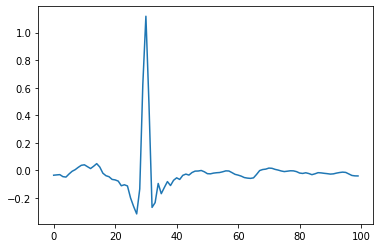

In [3]:
plt.plot(signal[1][200:300])

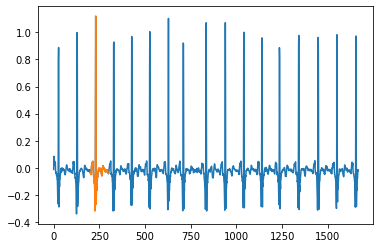

In [7]:
plt.plot(signal[1][0:len(signal[1])])
n = [i for i in range(200,300)]
plt.plot(n, signal[1][200:300])

In [ ]:
signal = ecg.ecg(signal=sig,  sampling_rate=fields['fs'] , show=False)

print(signal[3].shape)
#print(signal[3])
plotsignal = signal[3].reshape( 1,signal[3].shape[0])
print(plotsignal.shape)
plt.plot(plotsignal[0])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix,  ConfusionMatrixDisplay
from sklearn.utils import resample

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_17588\2167698492.py:26: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  R_peaks = np.array(R_peaks, dtype = 'float')


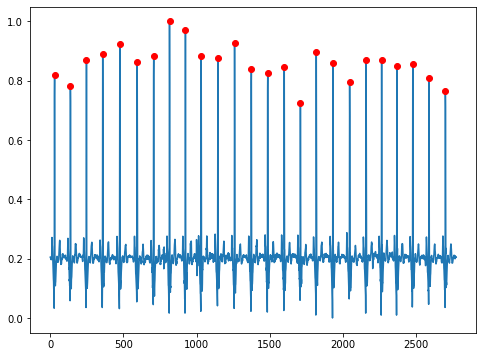

(12, 187)


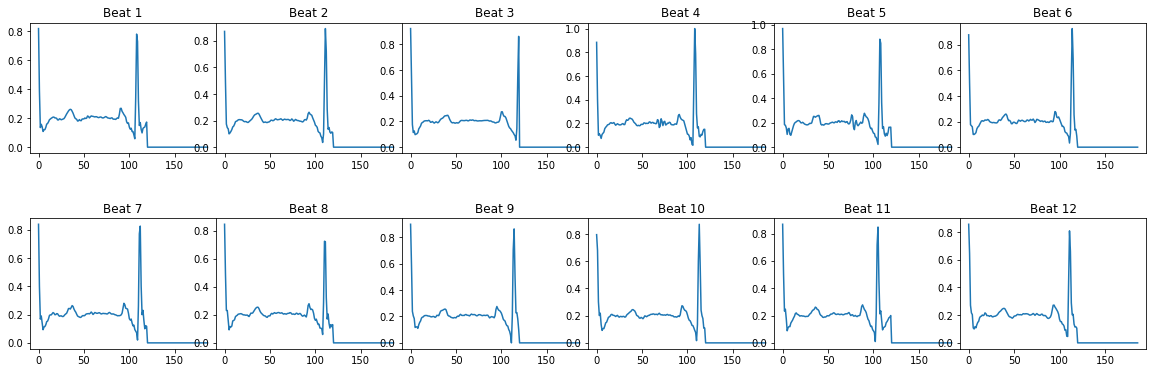

In [2]:
import wfdb
import math
from wfdb import processing
import matplotlib.pyplot as plt
from biosppy.signals import ecg
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram

def zero_to_nan(array):
    """ Return nan for any value = 0"""
    return [float('nan') if x==0 else x for x in array]

def process_beat(signal):
  signalECG = processing.normalize_bound(signal[1], lb=0, ub=1)
  R_p_index = signal[2]
  #heartbeat = []
  #multi_heartbeat = []
  multi_heartbeat = np.zeros((1,187), dtype = float)
  R_peaks = np.zeros((len(signalECG), 1), dtype = float)
  for i in range(len(R_p_index)):
    R_peaks[R_p_index[i]] = signalECG[R_p_index[i]]
  R_peaks = zero_to_nan(R_peaks)
  R_peaks = np.array(R_peaks, dtype = 'float')
  j = 0
  c_p = 0
  
  plt.figure(figsize=(8, 6))
  plt.plot(signalECG)
  plt.plot(R_peaks, 'ro')
  plt.show()
  R_inter = np.zeros((2,), dtype = int)
  for i in range(len(signalECG)):
      if R_peaks[i] == signalECG[i]:
        R_inter[c_p] = i
        c_p = c_p + 1
      if c_p == 2:
        c_p = 0
        T_inter = abs(120 - R_inter[1] + R_inter[0])
        #print(f"T_inter = {T_inter}")
        crop_signal = signalECG[R_inter[0]:R_inter[1]+T_inter].flatten()
        heartbeat = crop_signal 
        heartbeat = np.append(heartbeat, np.zeros((1,187 - len(crop_signal)), dtype = float))
        heartbeat = np.reshape(heartbeat,(1, len(heartbeat)))
        #print(f"heartbeat = {heartbeat}")
        multi_heartbeat = np.insert(multi_heartbeat, -1, heartbeat, axis = 0)
        #print(f"multi_heartbeat = {multi_heartbeat}")
  multi_heartbeat = np.delete(multi_heartbeat, -1, axis = 0)      
  print(multi_heartbeat.shape)
  return multi_heartbeat

path = 'mit-bih-arrhythmia-database-1.0.0/101'

freq_model = 125
number_of_sample = 168
sampfrom = 0
sampto = 8000
record = wfdb.rdrecord(path,channels = [0], sampfrom= 0, sampto= 3600) 
sig, fields = wfdb.rdsamp(path,channels = [0], sampfrom= sampfrom, sampto = sampto)
sig = sig.flatten()
#ecgann = wfdb.rdann(path, 'atr', sampfrom= sampfrom, sampto= sampto)
#signew, ann = wfdb.processing.resample_singlechan(x=sig, ann = ecgann, fs=fields['fs'], fs_target=freq_model)

sig, resampled_t = processing.resample_sig(sig, fields['fs'], freq_model)
signal = ecg.ecg(signal=sig,  sampling_rate= freq_model , show=False)



lead = process_beat(signal)

fig, axs = plt.subplots(2, math.ceil(lead.shape[0]/2), figsize=(20, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i, beat in enumerate(lead):

    axs[i].plot(beat)
    axs[i].set_title(f"Beat {i+1}")

In [3]:
model_test = tf.keras.models.load_model("senior_multi_diseases_2.h5")
#model_test.summary()
new_lead = lead.reshape(lead.shape[0], lead.shape[1], 1)

output = model_test.predict(new_lead)
 
model_output = np.argmax(output, axis = 1)
print(model_output)

: 

: 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix,  ConfusionMatrixDisplay
from sklearn.utils import resample

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

In [3]:
model_test1 = tf.keras.models.load_model("senior_multi_diseases_2.h5")
model_test2 = tf.keras.models.load_model("CVDs_khanh2.h5")
model_test3 = tf.keras.models.load_model("CVDs_khanh3.h5")
model_test4 = tf.keras.models.load_model("CVDs_khanh4.h5")
model_test5 = tf.keras.models.load_model("CVDs_khanh5.h5")

In [ ]:
path = 'mit-bih-arrhythmia-database-1.0.0/117'

2272


C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_15364\1921898103.py:35: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  R_peaks = np.array(R_peaks, dtype = 'float')


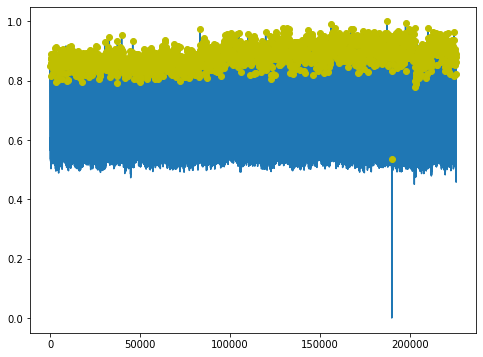

(2271, 120)
(2271, 187)


In [14]:
path = 'mit-bih-arrhythmia-database-1.0.0/100'
from biosppy.signals import ecg
import wfdb
import math
from wfdb import processing
import matplotlib.pyplot as plt
from biosppy.signals import ecg
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram

def zero_to_nan(array):
    """ Return nan for any value = 0"""
    return [float('nan') if x==0 else x for x in array]

#path = 'mit-bih-arrhythmia-database-1.0.0/111'
freq_model = 125
number_of_sample = 168
sampfrom = 0
sampto = 8000
sig, fields = wfdb.rdsamp(path,channels = [0], sampfrom= sampfrom)
sig = sig.flatten()
sig, resampled_t = processing.resample_sig(sig, fields['fs'], freq_model)
signal = ecg.ecg(signal=sig,  sampling_rate= freq_model , show=False)
r_index = signal[2]
print(len(r_index))
sigECG = processing.normalize_bound(sig, lb=0, ub=1)

R_peaks = np.zeros((len(sigECG), 1), dtype = float)
for i in range(len(r_index)):
    R_peaks[r_index[i]] = sigECG[r_index[i]]
R_peaks = zero_to_nan(R_peaks)
R_peaks = np.array(R_peaks, dtype = 'float')

plt.figure(figsize = (8,6))
plt.plot(sigECG)
plt.plot(R_peaks, 'yo')
plt.show()

signalnew, num_beat = ecg.extract_heartbeats(sigECG, signal[2], sampling_rate=125, before = 0, after = 0.96)

print(signalnew.shape)
multi_heartbeat = np.zeros((1,187), dtype = float)
for i in range(signalnew.shape[0]):
    heartbeat = signalnew[i]
    heartbeat = np.append(heartbeat, np.zeros((1, 187 - (signalnew.shape[1])), dtype = float))
    multi_heartbeat = np.insert(multi_heartbeat, -1, heartbeat, axis = 0)
multi_heartbeat = np.delete(multi_heartbeat, -1, axis = 0)
print(multi_heartbeat.shape)

#fig, axs = plt.subplots(4, math.ceil(multi_heartbeat.shape[0]/4), figsize=(30, 12), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.001)

#axs = axs.ravel()

#for i, beat in enumerate(multi_heartbeat):

    #axs[i].plot(beat)
    #axs[i].set_title(f"Beat {i+1}")

In [6]:
import collections
multi_heartbeat = multi_heartbeat.reshape(multi_heartbeat.shape[0], multi_heartbeat.shape[1], 1)

output1 = model_test1.predict(multi_heartbeat)
output2 = model_test2.predict(multi_heartbeat)
output3 = model_test3.predict(multi_heartbeat)
output4 = model_test4.predict(multi_heartbeat)
output5 = model_test5.predict(multi_heartbeat)

model_output1 = np.argmax(output1, axis = 1)
model_output2 = np.argmax(output2, axis = 1)
model_output3 = np.argmax(output3, axis = 1)
model_output4 = np.argmax(output4, axis = 1)
model_output5 = np.argmax(output5, axis = 1)

count1 = collections.Counter(model_output1)
count2 = collections.Counter(model_output2)
count3 = collections.Counter(model_output3)
count4 = collections.Counter(model_output4)
count5 = collections.Counter(model_output5)
print(f"Count1 = {count1}")
print(f"Count2 = {count2}")
print(f"Count3 = {count3}")
print(f"Count4 = {count4}")
print(f"Count5 = {count5}")

71/71 [==============================] - 0s 5ms/step
Count1 = Counter({0: 2231, 1: 39, 2: 1})
Count2 = Counter({0: 2232, 1: 26, 2: 13})
Count3 = Counter({0: 2268, 1: 2, 2: 1})
Count4 = Counter({0: 2266, 1: 3, 2: 2})
Count5 = Counter({0: 2233, 2: 32, 1: 6})


In [ ]:
# Setting Dictionary to define the type of Heartbeat
# N: normal
#S: Supraventricular premature beat
#P: Premature ventricular contraction
#F: Fusion of ventricular and normal beat
#U: Unclassifiable beat
MIT_Outcome = {0. : 'N',
               1. : 'S',
               2. : 'P',
               3. : 'F',
               4. : 'U'}

In [ ]:
test, out_test = mit_test.iloc[:,:187], mit_test["Class"]
test = normalize(test, axis = 0, norm='max')
print(test.shape)

In [ ]:
a = np.array([[1,2,1],
             [2,3,2],
             [3,4,5]])

print(a[1])

In [ ]:
class0 = mit_test[mit_test["Class"] == 0]
class1 = mit_test[mit_test["Class"] == 1]
class2 = mit_test[mit_test["Class"] == 2]
class3 = mit_test[mit_test["Class"] == 3]
class4 = mit_test[mit_test["Class"] == 4]
class0.iloc[0,:187].plot()
plt.show()
class1.iloc[0,:187].plot()
plt.show()
class2.iloc[0,:187].plot()
plt.show()
class3.iloc[0,:187].plot()
plt.show()
class4.iloc[0,:187].plot()
plt.show()